In [13]:
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

base_dir = "/kaggle/input/teeth-dataset/Teeth_Dataset"  
print(os.listdir(base_dir))


['Validation', 'Training', 'Testing']


In [2]:
train_dir = "/kaggle/input/teeth-dataset/Teeth_Dataset/Training"
val_dir   = "/kaggle/input/teeth-dataset/Teeth_Dataset/Validation"
test_dir  = "/kaggle/input/teeth-dataset/Teeth_Dataset/Testing"

print("Train classes:", os.listdir(train_dir))
print("Validation classes:", os.listdir(val_dir))
print("Test classes:", os.listdir(test_dir))


Train classes: ['OC', 'CaS', 'OT', 'CoS', 'Gum', 'MC', 'OLP']
Validation classes: ['OC', 'CaS', 'OT', 'CoS', 'Gum', 'MC', 'OLP']
Test classes: ['OC', 'outputs', 'output', 'CaS', 'out', 'OT', 'CoS', 'output_image.jpg', 'Gum', 'MC', 'OLP']


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size = (224, 224)
batch_size = 32

valid_classes = ['OC', 'CaS', 'OT', 'CoS', 'Gum', 'MC', 'OLP']


# Preprocessing & Augmentation 

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    classes=valid_classes,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    classes=valid_classes,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    classes=valid_classes,
    shuffle=False
)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [6]:
print("Class indices:", train_generator.class_indices)
print("Total training images:", train_generator.samples)
print("Total validation images:", val_generator.samples)
print("Total testing images:", test_generator.samples)

Class indices: {'OC': 0, 'CaS': 1, 'OT': 2, 'CoS': 3, 'Gum': 4, 'MC': 5, 'OLP': 6}
Total training images: 3087
Total validation images: 1028
Total testing images: 1028


# distribution of the classes

In [8]:
def plot_class_distribution(generator, title="Class Distribution", palette="rocket"):
    counts = Counter(generator.classes)
    labels = list(generator.class_indices.keys())

    plt.figure(figsize=(10,5))
    ax = sns.barplot(
        x=labels,
        y=[counts[i] for i in range(len(labels))],
        palette=palette,
        order=labels  
    )
    plt.title(title, fontsize=16)
    plt.ylabel("Number of images")
    plt.xlabel("Classes")
    
    for i, val in enumerate([counts[i] for i in range(len(labels))]):
        ax.text(i, val + max(counts.values())*0.01, str(val), ha='center')
    
    plt.show()

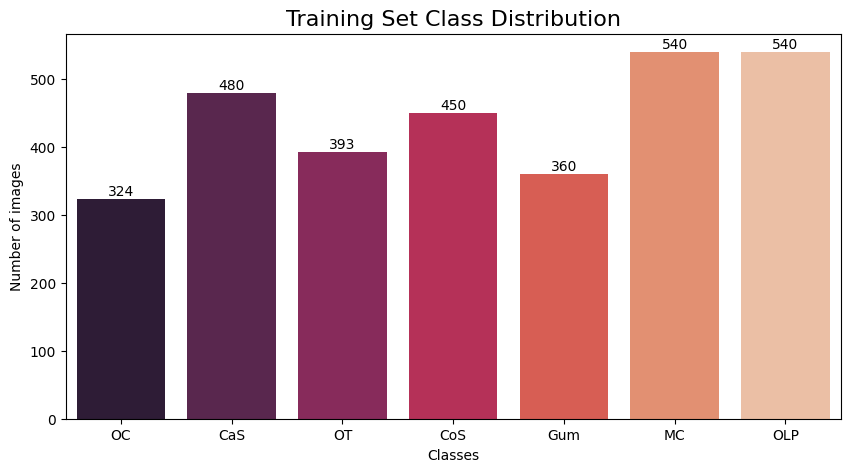

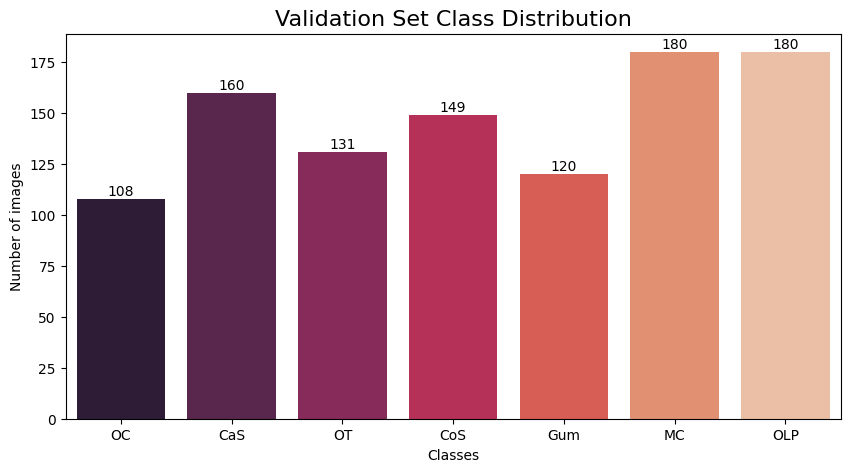

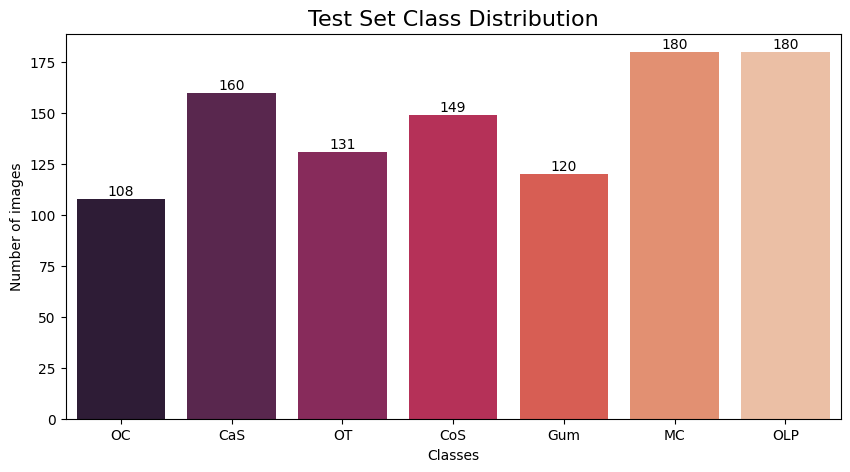

In [20]:
plot_class_distribution(train_generator, "Training Set Class Distribution")
plot_class_distribution(val_generator, "Validation Set Class Distribution")
plot_class_distribution(test_generator, "Test Set Class Distribution")

# Original VS Augmented 

In [9]:
def multi_aug(orig, datagen, n=5, k=3):

    plt.figure(figsize=(3*(k+1), 3*n))
    for i in range(n):
        ax = plt.subplot(n, k+1, i*(k+1) + 1)
        ax.imshow(orig[i])
        ax.set_title("Original")
        ax.axis("off")

        for j in range(k):
            aug_img = datagen.random_transform(orig[i])
            ax = plt.subplot(n, k+1, i*(k+1) + j + 2)
            ax.imshow(aug_img)
            ax.set_title(f"Aug {j+1}")
            ax.axis("off")
    plt.tight_layout()
    plt.show()

Found 3087 images belonging to 7 classes.


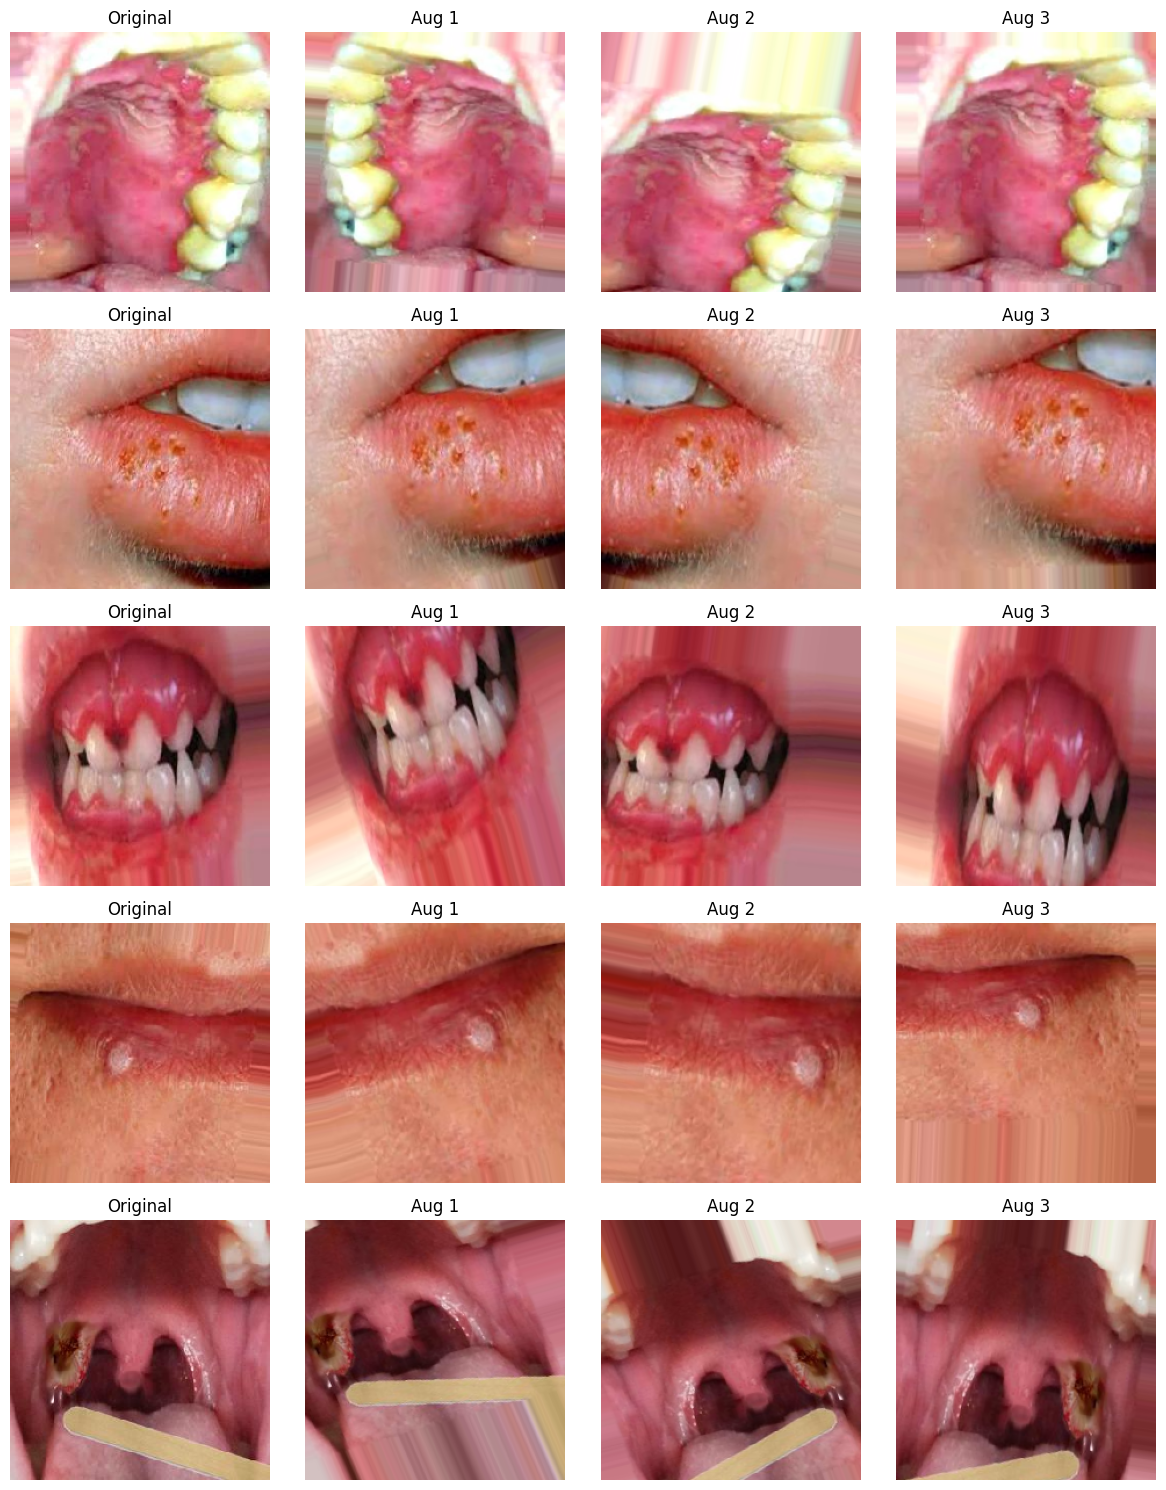

In [11]:
orig_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode="categorical", shuffle=True)

orig, _ = next(orig_gen)

multi_aug(orig, train_datagen, n=5, k=3)

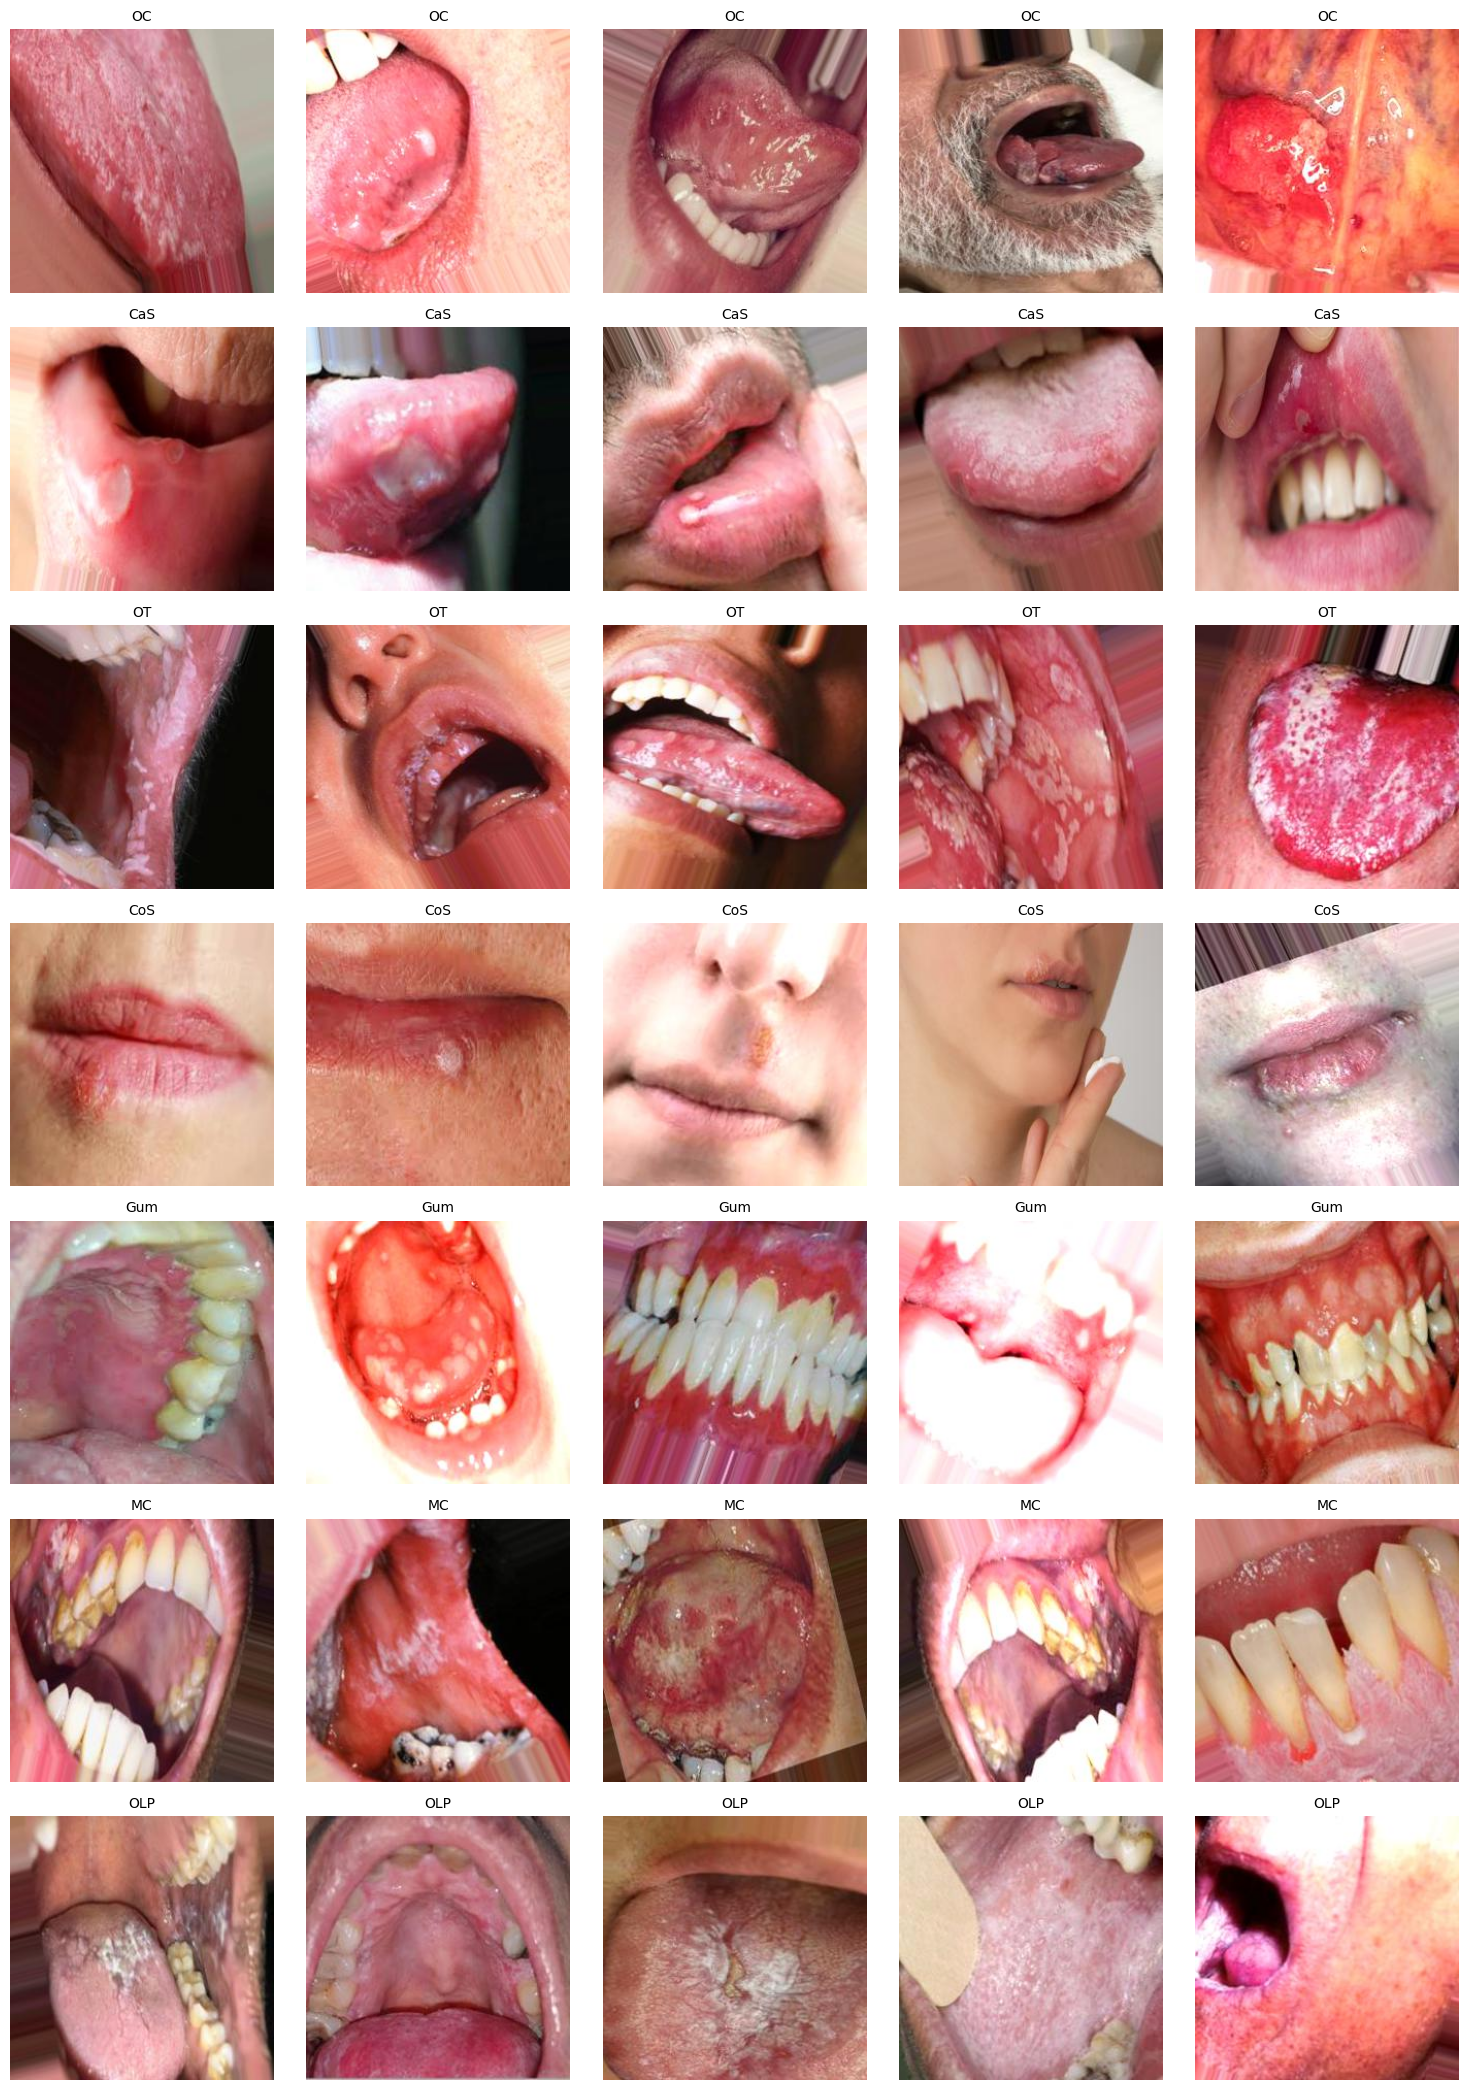

In [14]:
class_names = list(train_generator.class_indices.keys())
samples_per_class = 5
plt.figure(figsize=(samples_per_class*3, len(class_names)*3))

for class_idx, class_name in enumerate(class_names):
    class_indices = np.where(train_generator.classes == class_idx)[0]
    chosen_indices = np.random.choice(class_indices, samples_per_class, replace=False)

    for i, idx in enumerate(chosen_indices):
        img_path = train_generator.filepaths[idx]
        img = plt.imread(img_path)
        
        ax = plt.subplot(len(class_names), samples_per_class, class_idx*samples_per_class + i + 1)
        ax.imshow(img)
        ax.set_title(class_name, fontsize=10)
        ax.axis("off")

plt.tight_layout()
plt.show()


# CNN Model 

In [16]:
def cnn(input_shape=(224,224,3), n_classes=7, dropout_rate=0.4): 
    regul = 1e-4
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, padding="same", kernel_regularizer=regularizers.l2(regul))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, padding="same", kernel_regularizer=regularizers.l2(regul))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, padding="same", kernel_regularizer=regularizers.l2(regul))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, padding="same", kernel_regularizer=regularizers.l2(regul))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="Baseline_CNN")
    return model

model = cnn()
model.summary()


Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 424,135 (1.62 MB)

 Trainable params: 423,175 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("baseline_cnn.h5", monitor="val_loss", save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 459ms/step - accuracy: 0.4982 - loss: 1.3434 - val_accuracy: 0.4173 - val_loss: 1.6438
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 36s 372ms/step - accuracy: 0.5309 - loss: 1.2956 - val_accuracy: 0.2461 - val_loss: 3.3649
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 386ms/step - accuracy: 0.5297 - loss: 1.2848 - val_accuracy: 0.3930 - val_loss: 1.7863
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 36s 371ms/step - accuracy: 0.5290 - loss: 1.2274 - val_accuracy: 0.3988 - val_loss: 1.8278
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 36s 371ms/step - accuracy: 0.5677 - loss: 1.1907 - val_accuracy: 0.5399 - val_loss: 1.2067
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 381ms/step - accuracy: 0.5922 - loss: 1.1218 - val_accuracy: 0.3239 - val_loss: 2.4445
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 388ms/step - accuracy: 0.5750 - loss: 1.1641 - val_accuracy: 0.5165 - val_loss: 1.3559
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 385ms/step - accuracy: 0.5787 - loss: 1.1773 - val_accu

In [20]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 1.3611111111111112, 1: 0.91875, 2: 1.1221374045801527, 3: 0.98, 4: 1.225, 5: 0.8166666666666667, 6: 0.8166666666666667}


In [24]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,          
    callbacks=callbacks,
    class_weight=class_weights  
)

Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 433ms/step - accuracy: 0.5684 - loss: 1.1791 - val_accuracy: 0.3327 - val_loss: 1.7499
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 378ms/step - accuracy: 0.5745 - loss: 1.1606 - val_accuracy: 0.2860 - val_loss: 2.6655
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 376ms/step - accuracy: 0.5712 - loss: 1.1481 - val_accuracy: 0.4640 - val_loss: 1.4699
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 36s 372ms/step - accuracy: 0.5917 - loss: 1.1195 - val_accuracy: 0.3872 - val_loss: 1.7510
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 377ms/step - accuracy: 0.5915 - loss: 1.1468 - val_accuracy: 0.4591 - val_loss: 1.5268
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 36s 373ms/step - accuracy: 0.5956 - loss: 1.0964 - val_accuracy: 0.5049 - val_loss: 1.3342
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 36s 371ms/step - accuracy: 0.5756 - loss: 1.1311 - val_accuracy: 0.4611 - val_loss: 1.6066
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 36s 371ms/step - accuracy: 0.5944 - loss: 1.1255 - val_accu

In [33]:
test_generator.reset()
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 322ms/step - accuracy: 0.5443 - loss: 1.1195
Test Accuracy: 0.5623, Test Loss: 1.1192


In [26]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


              precision    recall  f1-score   support

          OC       0.10      0.17      0.12       108
         CaS       0.13      0.07      0.10       160
          OT       0.23      0.08      0.12       131
         CoS       0.17      0.19      0.18       149
         Gum       0.08      0.16      0.11       120
          MC       0.16      0.23      0.19       180
         OLP       0.19      0.06      0.09       180

    accuracy                           0.14      1028
   macro avg       0.15      0.14      0.13      1028
weighted avg       0.16      0.14      0.13      1028



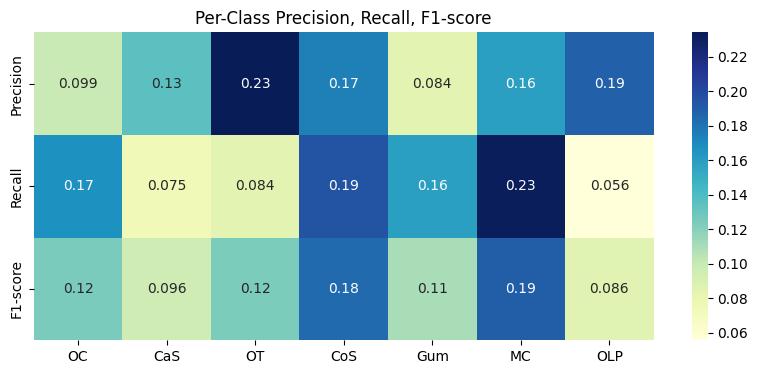

In [27]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred)
metrics = np.array([precision, recall, f1])

plt.figure(figsize=(10,4))
sns.heatmap(metrics, annot=True, cmap="YlGnBu", xticklabels=class_names, yticklabels=["Precision", "Recall", "F1-score"])
plt.title("Per-Class Precision, Recall, F1-score")
plt.show()


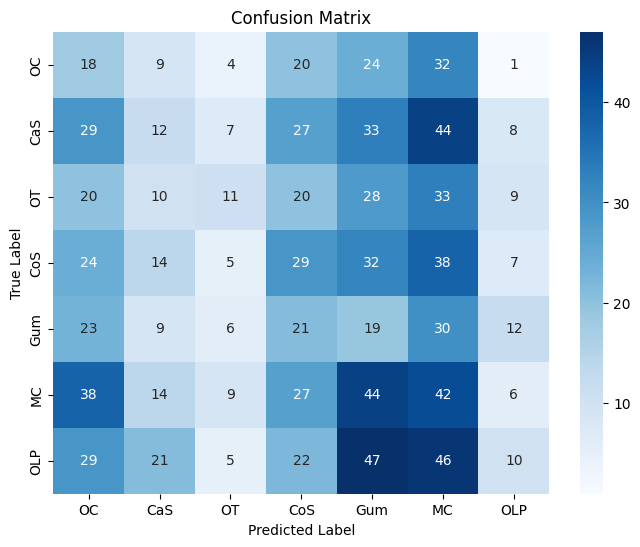

In [28]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()


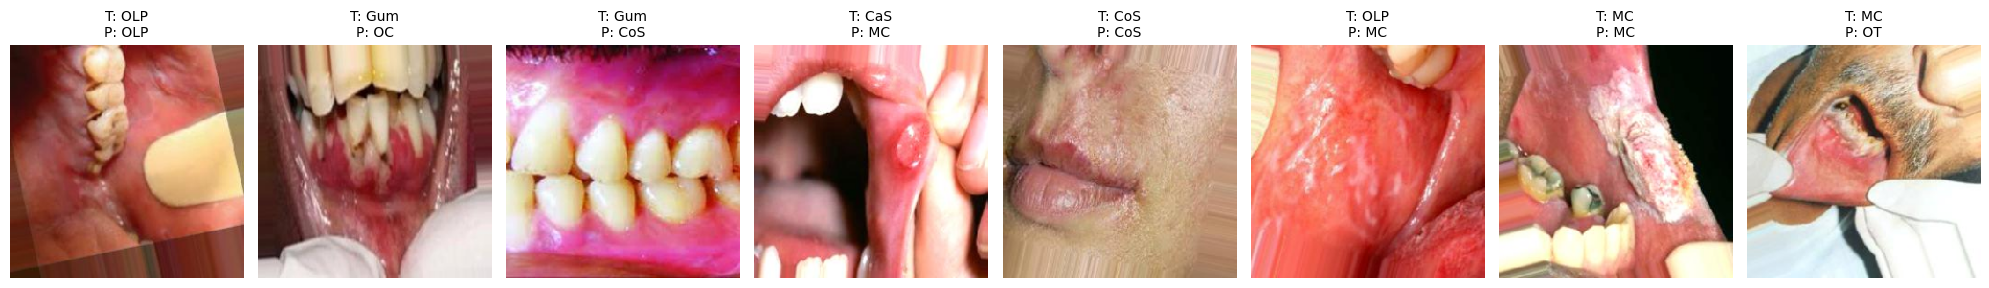

In [32]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

num_samples = 8

indices = np.random.choice(len(y_true), num_samples, replace=False)

plt.figure(figsize=(20, 5))

for i, idx in enumerate(indices):
    img_path = val_generator.filepaths[idx]  
    img = load_img(img_path, target_size=(224, 224))

    ax = plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    
    ax.set_title(f"T: {true_label}\nP: {pred_label}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Training vs Validation Accuracy')

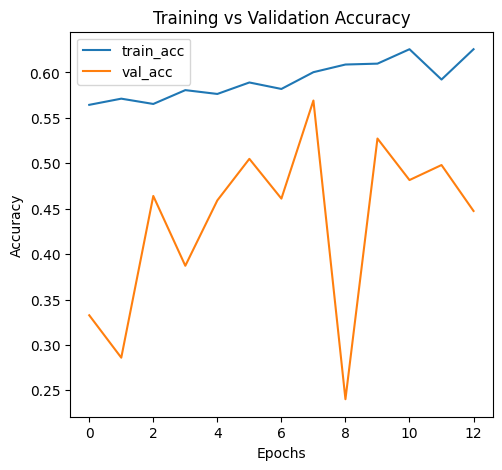

In [35]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')


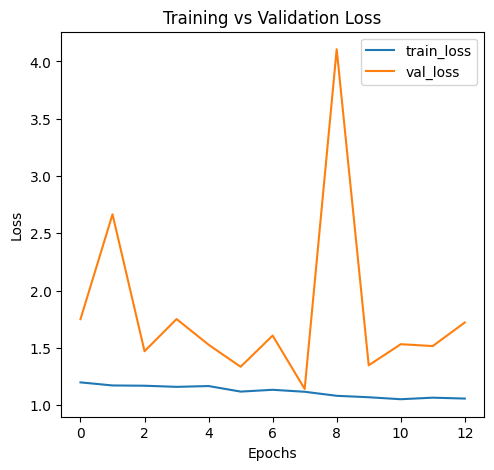

In [36]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()


In [37]:
model.save("final_dental_cnn.h5")
